# Abstract

In this notebook, I use a simple logistic regression classifier on a dataset of 10,000 tweets to predict whether the tweet refers to a true "disaster" event, or whether the tweet is irrelevant. I focus on the interpretability of simple classification models and what that means for text data. I look at a few methods of creating text embeddings for NLP tasks and explain the use and demonstrate the significant advantages of incorporating semantic meaning into NLP tasks using models such as Word2Vec.

I extend on the interpretability of NLP models by using LIME to understand predictions made on Word2Vec embeddings, and finally, I attempt to incorporate the syntactic structure of tweets into a model's predictions by building a 1D CNN for text classification on top of Word2Vec embeddings. 

The point of this notebook is to serve as an intro to NLP to get direction for where and how to proceed in improving the performance of text clustering and classification algorithms, whether that entails further dataset processing - a commonly productive endeavour - or in employing a more complicated model.

The steps I've taken here constitute a good baseline to get started on an NLP project, though by no means are they comprehensive. 

<!--TABLE OF CONTENTS-->
# Table of Contents:
- [Intro](#Intro)
- [The Dataset](#The-Dataset)
  - [Inspecting and Cleansing the Dataset](#Inspecting-and-Cleansing-the-Dataset)
  - [Tokenization](#Tokenization)
- [Text Embeddings](#Text-Embeddings)
  - [Bag of Words](#Bag-of-Words)
  - [Visualizing the Embeddings with LSA](#Visualizing-the-Embeddings-with-LSA)
- [Fitting a Classifier for Baseline Performance](#Fitting-a-Classifier-for-Baseline-Performance)
  - [Evaluation](#Evaluation)
  - [Inspection](#Inspection)
  - [Interpretability](#Interpretability)
- [TF-IDF Bag of Words](#TF-IDF-Bag-of-Words)
- [Understanding Semantic Meaning](#Understanding-Semantic-Meaning)
  - [Word2Vec](#Word2Vec)
- [Intepretability with LIME](#Intepretability-with-LIME)
- [Using CNNs for Text Classification](#Using-CNNs-for-Text-Classification)
  - [Preprocessing: Padding and One-Hot Encoding](#Preprocessing:-Padding-and-One-Hot-Encoding)
  - [1D Word2Vec CNN](#1D-Word2Vec-CNN)
- [Take-Away](#Take-Away)

# Intro

There are a wealth of fancy NLP algorithms available today - particularly using transformers, which has overshadowed a lot of the basics of NLP such as clustering and classification. However, simple algorithms are much easier to scale and often provide an excellent basis before building more complicated models. 

I'm going to work through the Twitter Disasters dataset originally made available by [Crowdflower](https://appen.com/resources/datasets/). I found it available [here](https://data.world/crowdflower/disasters-on-social-media).

## The Dataset
10,000 tweets are labeled as whether referring to a disaster (such as a flood, a pandemic) or not. I'm going to classify tweets as being truly related to disasters, or otherwise - memes and similar positive tweets often share words with negative tweets, so this may be somewhat challenging to get right.

Predicting relevance of tweets is an actionable problem if the data can be made available to first response teams such as police departments, hospitals, and mental health professionals. 

In [428]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import io
from IPython.display import display

### Inspecting and Cleansing the Dataset
Let's check the structure of our dataset so we can get an idea of what preprocessing we should do. 

We first take each line the dataset and write it to a new UTF-8 encoded file to make sure it's readable. We replace encoding errors with '?' and avoid getting a 'UnicodeDecodeError' error back. Note that we might want to replace encoding/decoding errors with the correct decoding manually in some instances. 

In [429]:
input_file = "socialmedia_relevant_cols.csv"
output_file = "social_media_text.csv"

# read and write file in utf-8 encoding to make sure it's readable
def sanitize_characters(raw, clean):    
    with io.open(raw, "r",encoding='utf-8', errors='replace') as input_file:
        with io.open(clean, "w", encoding='utf-8') as output_file:
            for line in input_file:
                out = line
                output_file.write(line)
                
sanitize_characters(input_file, output_file)

Let's check the structure:

In [430]:
tweets = pd.read_csv("social_media_text.csv")
display(tweets.head())
display(tweets.tail())

text choose_one  class_label
0                 Just happened a terrible car crash   Relevant            1
1  Our Deeds are the Reason of this #earthquake M...   Relevant            1
2  Heard about #earthquake is different cities, s...   Relevant            1
3  there is a forest fire at spot pond, geese are...   Relevant            1
4             Forest fire near La Ronge Sask. Canada   Relevant            1

text choose_one  \
10871  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...   Relevant   
10872  Police investigating after an e-bike collided ...   Relevant   
10873  The Latest: More Homes Razed by Northern Calif...   Relevant   
10874  MEG issues Hazardous Weather Outlook (HWO) htt...   Relevant   
10875  #CityofCalgary has activated its Municipal Eme...   Relevant   

       class_label  
10871            1  
10872            1  
10873            1  
10874            1  
10875            1

We have three columns: the text content of the tweet, the classification of the tweet into "relevant" or "irrelevant", and the corresponding integer class label.

We're going to remove unwanted characters such as URLs, @ signs, hashtags, and non alphanumerical characters. We'll also convert to all lowercase.

I'll use regexp to do the above. 

In [431]:
# cleanse tweets to only contain alphanumerical characters 
def clean_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "") # remove URL protocol with trailing whitespace
    df[text_field] = df[text_field].str.replace(r"http", "") # remove URL protocol
    df[text_field] = df[text_field].str.replace(r"@\S+", "") # remove at signs with leading spaces 
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ") # remove non-alphanumerical
    df[text_field] = df[text_field].str.replace(r"@", "at") # replace at signs with "at"
    df[text_field] = df[text_field].str.lower() # convert all to lowercase
    return df

tweets = pd.read_csv("social_media_text.csv")
tweets_df = clean_text(tweets, "text")
tweets_df.to_csv("social_media_clean.csv")
display(tweets_df.head())
display(tweets_df.tail())

text choose_one  class_label
0                 just happened a terrible car crash   Relevant            1
1  our deeds are the reason of this  earthquake m...   Relevant            1
2  heard about  earthquake is different cities, s...   Relevant            1
3  there is a forest fire at spot pond, geese are...   Relevant            1
4             forest fire near la ronge sask  canada   Relevant            1

text choose_one  \
10871        m1 94  01 04 utc ?5km s of volcano hawaii     Relevant   
10872  police investigating after an e bike collided ...   Relevant   
10873  the latest  more homes razed by northern calif...   Relevant   
10874        meg issues hazardous weather outlook (hwo)    Relevant   
10875   cityofcalgary has activated its municipal eme...   Relevant   

       class_label  
10871            1  
10872            1  
10873            1  
10874            1  
10875            1

We can check the class blanace - 0 refers to irrelevant, 1 refers to disasters, and class 2 is unlabeled. 

In [432]:
clean_tweets = pd.read_csv("social_media_clean.csv")
display(clean_tweets.groupby("class_label").count())

Unnamed: 0  text  choose_one
class_label                              
0                  6187  6187        6187
1                  4673  4673        4673
2                    16    16          16

The irrelevant class is about 35% oversampled, but that shoudln't be an issue. Almost all tweets are labelled as one of two classes. 

Let's remove the unlabelled class which only has 16 tweets.

In [433]:
clean_tweets = clean_tweets[clean_tweets['class_label'] != 2]
display(clean_tweets.groupby("class_label").count())

Unnamed: 0  text  choose_one
class_label                              
0                  6187  6187        6187
1                  4673  4673        4673

### Tokenization
We need to convert the text from the tweets into a form we can process algorithmically. We can tokenize our text to split it into separate words. I use NLTK's built in tokenizer for this task.

In [434]:
from nltk.tokenize import RegexpTokenizer

# tokenizer for words, i.e. any length word (alphanumeric) characters separated by a whitespace
tokenizer = RegexpTokenizer(r'\w+')

clean_tweets["tokens"] = clean_tweets["text"].apply(tokenizer.tokenize)
clean_tweets.head()

Unnamed: 0                                               text choose_one  \
0           0                 just happened a terrible car crash   Relevant   
1           1  our deeds are the reason of this  earthquake m...   Relevant   
2           2  heard about  earthquake is different cities, s...   Relevant   
3           3  there is a forest fire at spot pond, geese are...   Relevant   
4           4             forest fire near la ronge sask  canada   Relevant   

   class_label                                             tokens  
0            1          [just, happened, a, terrible, car, crash]  
1            1  [our, deeds, are, the, reason, of, this, earth...  
2            1  [heard, about, earthquake, is, different, citi...  
3            1  [there, is, a, forest, fire, at, spot, pond, g...  
4            1      [forest, fire, near, la, ronge, sask, canada]

Now we can check the distribution of our dataset with respect to the words contained therein, which is the vocabulary of the dataset:

In [435]:
# get a list of all words in the tokenized tweets 
all_words = [word for tokens in clean_tweets["tokens"] for word in tokens]

# get a list of tweet lengths in the set tokenized tweets
sentence_lengths = [len(tokens) for tokens in clean_tweets["tokens"]]

# list all unique words in the dataset and sort it for future convenience
VOCAB = sorted(list(set(all_words)))

print(f'{len(all_words)} words total, vocabulary size of {len(VOCAB)}')
print(f'Max sentence length is {max(sentence_lengths)}')

154569 words total, vocabulary size of 18088
Max sentence length is 34


Plot the results to visualize:

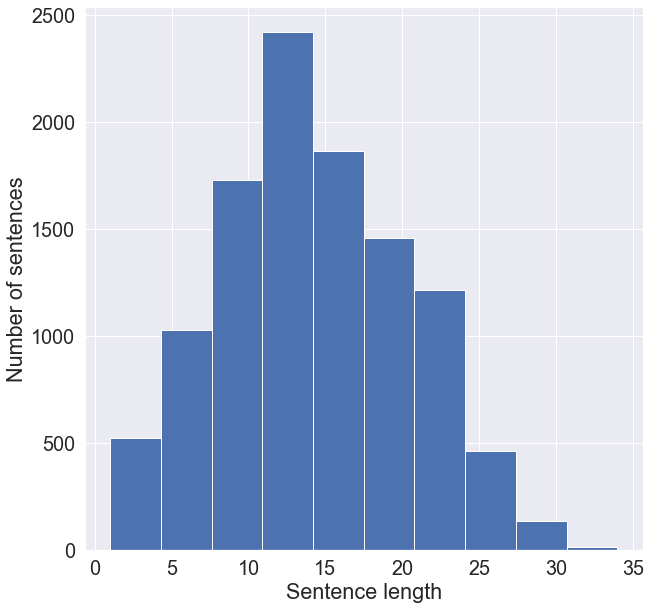

In [436]:
import matplotlib.pyplot as plt

# plot histogram of sentence lengths vs their frequency of occurence 
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

## Text Embeddings
We can process images by converting them to pixel values, audio by converting to features engineered on waveforms - and similarly, we need to convert text into embeddings for use in NLP algorithms. Embeddings are an encoded representation of text that makes it more feasible and efficient for machine learning algorithms to process it. 

We need to create a representation of each tweet - which is represented as a sentence - in the dataset. That way we can process it numerically. Bag of words is the simplest approach, where we embed all words in our vocabulary into a vector - the index of each element in the vactor corresponds to a word in the dataset's vocabulary, and the value at each index is the number of times a word appears in a sentence. Each sentence will be embedded into one such vector. 


## Bag of Words 

In [437]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# function to transform tweets to vectorized bag of word embedding
def vectorizer(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

# set of all tweet text
list_corpus = clean_tweets["text"].tolist()
# set of all tweet class labels
list_labels = clean_tweets["class_label"].tolist()

# split into 80/20 train/test 
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=69)

# convert training and test set word to bag of words vectorized representation
X_train_counts, count_vectorizer = vectorizer(X_train)
X_test_counts = count_vectorizer.transform(X_test)

### Visualizing the Embeddings with LSA

We can visualize the tweet bag of word vector embeddings to see if there's any inherent structure to the two classes that might help us differentiate between them. We hope to see some separation between the two class embeddings, but this is rarely the case at this stage. 

With a vocabulary size of 18k words, we have 18,000-dimensional data. We can't visualize that, so I'll use a singular value decomposition (SVD) method to reduce its dimensionality - latent semantic analysis (LSA), which is similar to PCA in that it is a form of SVD. However, LSA is specifically intended to reduce and analyze text data

LSA produces a matrix with rows represent unique words and columns representing each document, which in our case is a tweet. LSA uses SVD to reduce the number of rows while preserving the similarity structure among columns.

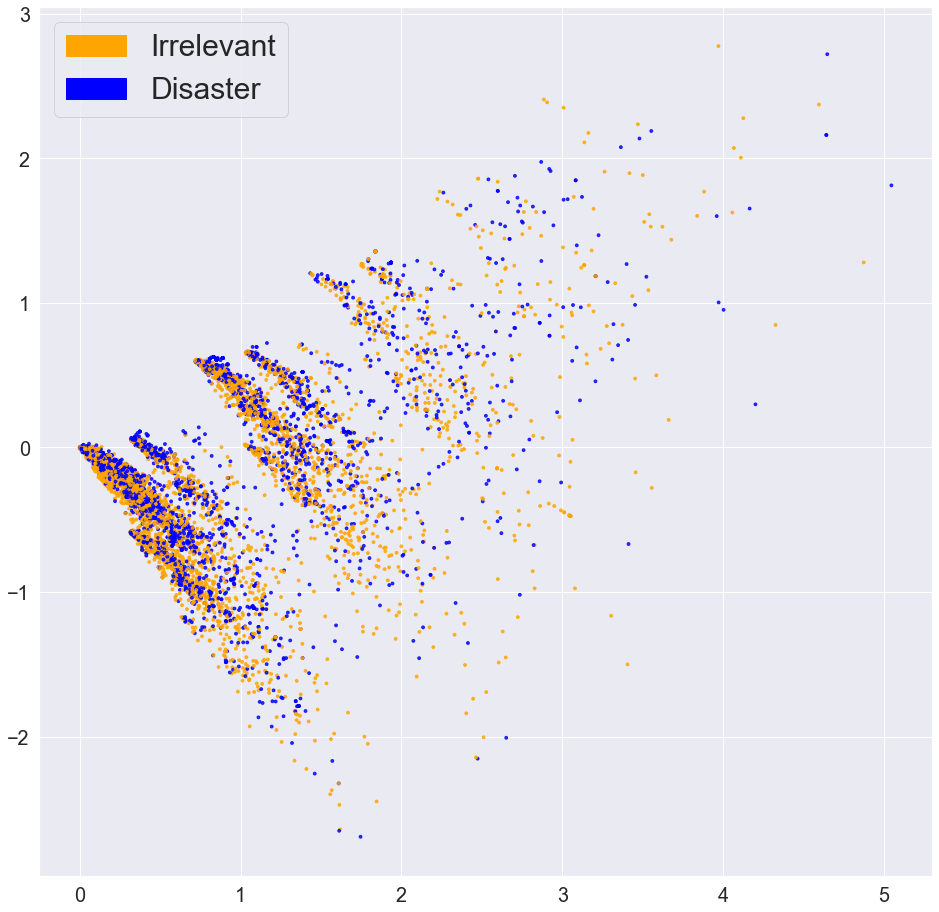

In [438]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

"Relevant" disaster tweets are poorly separeated from "irrelevant" tweets. 

### Fitting a Classifier for Baseline Performance


We can get a baseline performance of an estimator before improving our tweet embeddings.

I'll start with logistic regression, which is simple and interpretable. 

In [439]:
from sklearn.linear_model import LogisticRegression

# define logistic regression model 
clf = LogisticRegression(
    C=30.0, 
    class_weight='balanced', 
    solver='newton-cg', 
    n_jobs=-1, 
    random_state=69
)

# fit model on training data
clf.fit(X_train_counts, y_train)

# get model predictions on bag of words vectorized test data
y_predicted_counts = clf.predict(X_test_counts)

### Evaluation
We'll check some classification metrics to get a baseline for the dataset before we work on the embedding.

In [440]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print(f'accuracy = {accuracy*100:.3f}%, precision = {precision*100:.3f}%, recall = {recall*100:.3f}%, f1 = {f1*100:.3f}%')

accuracy = 77.901%, precision = 77.856%, recall = 77.901%, f1 = 77.872%


Not bad for the little effort put into the dataset itself. The performance between false negatives and false positives appears completely balanced. 

### Inspection
Let's take a closer look at where the model is making mistakes by inspecting the confusion matrix:

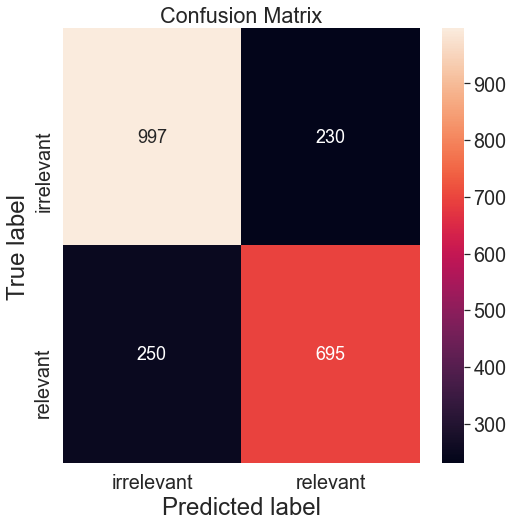

In [441]:
from sklearn.metrics import confusion_matrix
import seaborn as sn # I like seaborn's confusion matrix over sklearn's default

# build confusion matrix and normalized confusion matrix
def plot_cm(y_test, y_predicted):
    
    # build matrix using sklearn's built in function
    conf_matrix = confusion_matrix(y_test, y_predicted)

    # set labels for matrix axes
    labels = ['irrelevant','relevant']

    # make a confusion matrix with labels using a DataFrame
    confmatrix_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

    # plot confusion matrices
    plt.figure(figsize=(8,8))
    sn.set(font_scale=1.8) # emotion label and title size
    plt.title('Confusion Matrix')
    sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18},  fmt='g') #annot_kws is value font
    plt.ylabel('True label', fontsize=24)
    plt.xlabel('Predicted label', fontsize=24)

    plt.show()
    
    return conf_matrix
    
cm_bagofwords = plot_cm(y_test, y_predicted_counts)

The logistic regression model we've made **predicts more false negatives (truly relevant tweets classified as irrelevant) compared to false positives. This is better than leaning more heavily towards false negatives - since false positives would put our model at odds with first responders, who do not have the time to investigate false positives.** 

### Interpretability
We should understand the features the model is basing its predictions on, especially since a logistic regression classifier is easy to decode using the coefficients it has assigned, in this case, to particular words.

**Since we essentially have a binary classificaiton, problem, model.coef_ refers to predicted outcome 1 (relevant) and -model.coef_ refers to predicted outcome 0 (irrelevant).** 

In [442]:
def get_most_important_features(vectorizer, coefficients, n=5):
    
    # convert index of word from vectorizer into the word 
    index_to_word = {index:word for word,index in count_vectorizer.vocabulary_.items()}
    
    # assign coefficient to word by matching the index of the coefficient and word
    word_importances = [(coef, index_to_word[index]) for index, coef in enumerate(clf.coef_[0])]
    sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
    top = sorted(sorted_coeff[:n], key = lambda x : x)
    bottom = sorted_coeff[-n:]
    classes = {
        'top':top,
        'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf.coef_, 20)

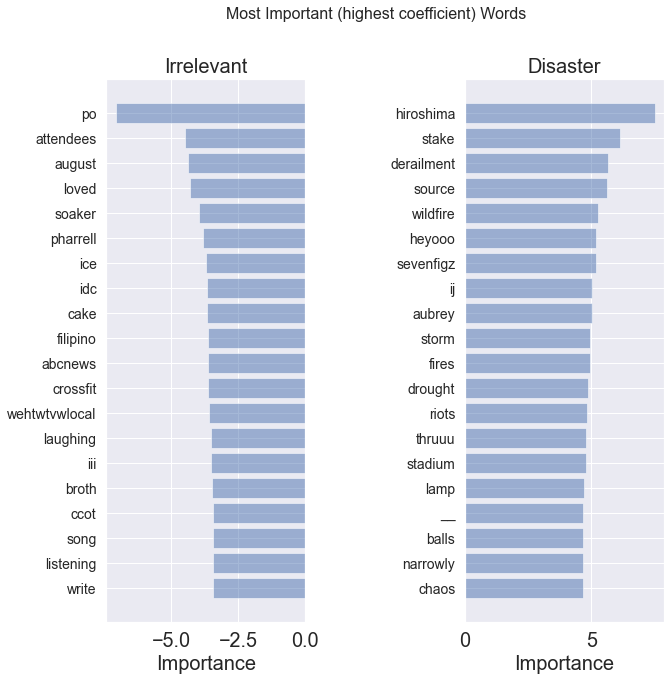

In [443]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, title):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  
    
    # plot words with most negative coefficients (irrelevant words)
    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    #plt.xlim(-8,0)
    
    # plot words with highest coefficients (relevant/disaster words)
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(title, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    #plt.xlim(0,8)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [word_score[0] for word_score in importance['top']]
top_words = [word_score[1] for word_score in importance['top']]
bottom_scores = [word_score[0] for word_score in importance['bottom']]
bottom_words = [word_score[1] for word_score in importance['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most Important (highest coefficient) Words")

This simple logistic regression model has a few things interpreted correctly - although the "irrelevance" of certain words is a dubious metric - it indeed seems none of the words with the most negative coefficients have any disastrous sentiment.

**The model has some relevant words picked out correctly, such as "storm", "riots", and "wildfire", but it is overfitting as well, which is evidenced by high-coefficient words like "heyooo", "sevenfigz", and "___".** 

### TF-IDF Bag of Words

We can improve the bag of words embedding by including the TF-IDF (Term Frequency - Inverse Document Frequency) statistics. TF-IDF weighs words according to the number of times they appear in a document (tweet) and offsets that by the number of documents (tweets) that contain the word - so TF-IDF **adjusts and lowers the importance of words that appear more frequently across all tweets in general.** This should lower the impact of noise in the dataset. 

In [444]:
# function to convert bag of words vectorized embeddings into TF-IDF embeddings
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

# create TF-IDF bag of words vectorized training and test sets from above function  
X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
# we already fit the TF-IDF vectorizer on this data, use same statistics for test set 
X_test_tfidf = tfidf_vectorizer.transform(X_test)

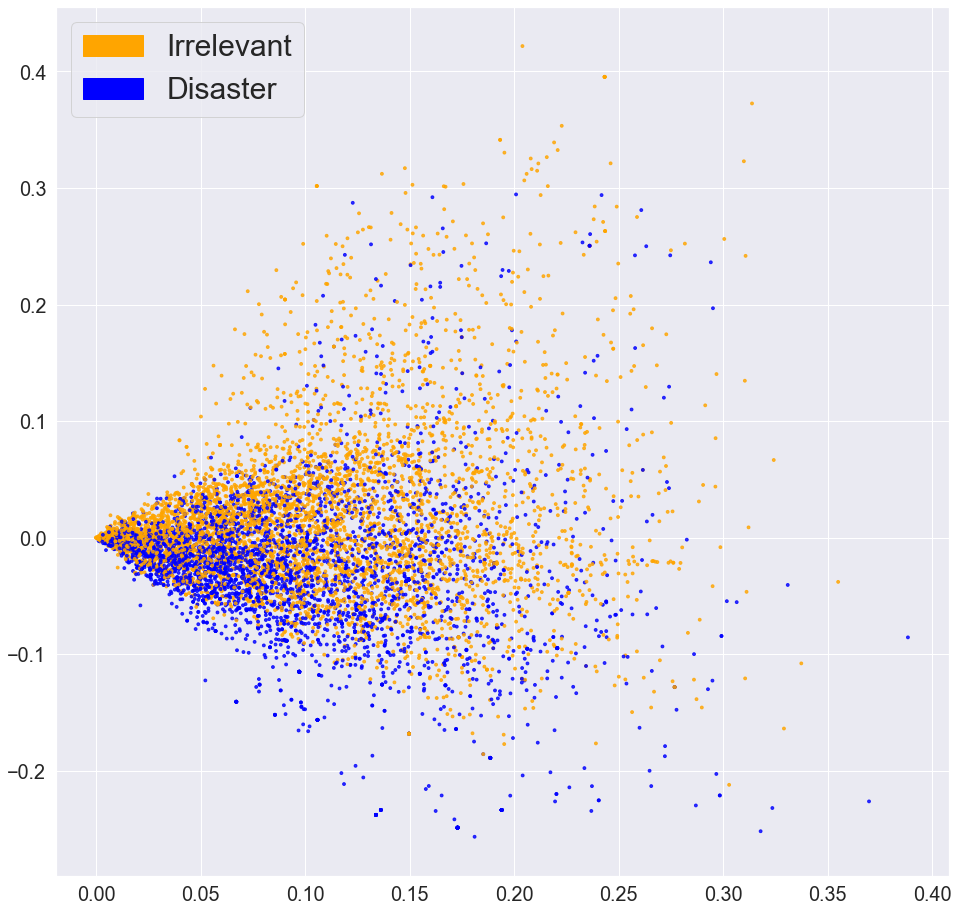

In [445]:
# plot the LSA reduced embeddings in 2 dimensions to see their separation
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

TF-IDF word embeddings appear to be much more clearly separated on this dataset, as expected. We can check if TF-IDF has improved the model's performance:

In [446]:
# define model to use on TF-IDF vectorized words (not strictly necessary; using same model)
clf_tfidf = LogisticRegression(
    C=30.0, 
    class_weight='balanced', 
    solver='newton-cg', 
    n_jobs=-1, 
    random_state=69
)

# fit model on TF-IDF embeddings
clf_tfidf.fit(X_train_tfidf, y_train)

# get predictiosn on TF-IDF embeddings
y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print(f'accuracy = {accuracy_tfidf*100:.3f}%, precision = {precision_tfidf*100:.3f}%, recall = {recall_tfidf*100:.3f}%, f1 = {f1_tfidf*100:.3f}%')

accuracy = 78.453%, precision = 78.470%, recall = 78.453%, f1 = 78.461%


Slightly better perhaps, but the performance of the model hasn't significantly changed.

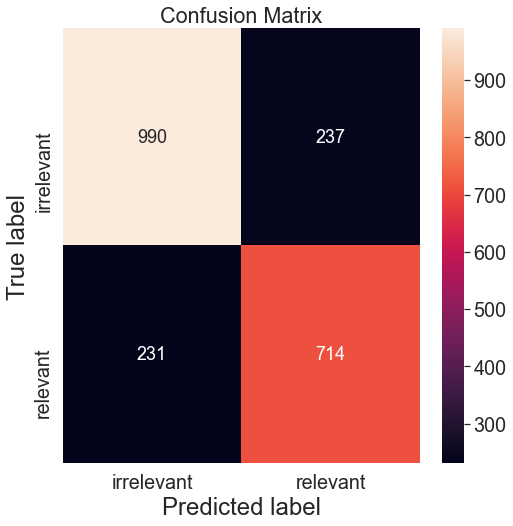

TF-IDF:
[[990 237]
 [231 714]]
Bag of Words:
[[997 230]
 [250 695]]


In [447]:
# plot confusion matrix on TF-IDF embeddings 
cm_tfidf = plot_cm(y_test, y_predicted_tfidf)
print(f'TF-IDF:\n{cm_tfidf}')
print(f'Bag of Words:\n{cm_bagofwords}')

**A more significant improvement: considerably fewer false negatives.** The model might have gained performance elsewhere as well. We can take a look again at the words the model considers important for predicting a disaster-relevant tweet. Perhaps there is some difference in the interpratibility of the model. 

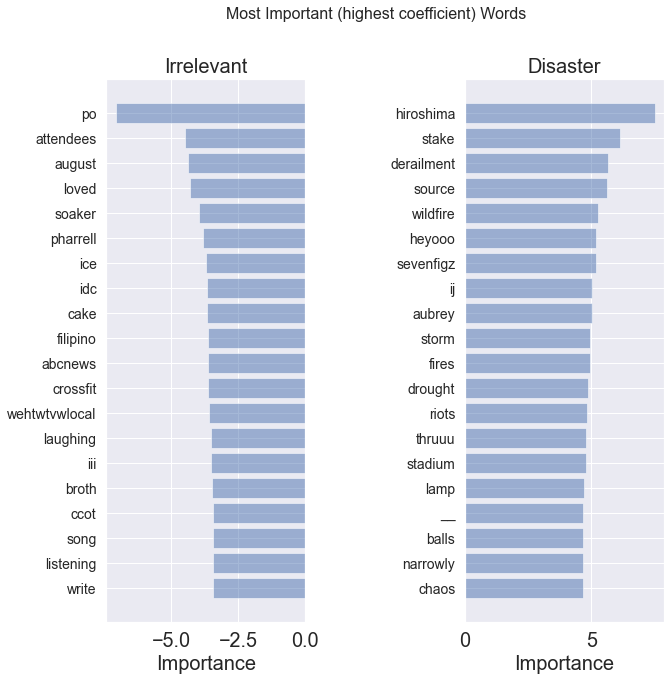

In [448]:
tfidf_importance = get_most_important_features(tfidf_vectorizer, clf_tfidf, 20)

top_scores = [word_score[0] for word_score in tfidf_importance['top']]
top_words = [word_score[1] for word_score in tfidf_importance['top']]
bottom_scores = [word_score[0] for word_score in tfidf_importance['bottom']]
bottom_words = [word_score[1] for word_score in tfidf_importance['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most Important (highest coefficient) Words")

**Unfortunately, TF-IDF hasn't made an improvement in interpretability. This is likely because noise wasn't an issue in the original model - it picks up on relevant words fairly well. The real issue is likely the model's inability to properly capture semantic meaning of the words themselves.** However, we can do better with more sophisticated text embeddings.

### Understanding Semantic Meaning 

The logistic regression model fit on the tweets embedded using bag of words and TF-IDF bag of words picks up on some highly relevant words, but also overfits on other completely irrelevant words. This is likely to be the case for any similar dataset, since **we will always capture both relevant and irrelevant words in a relevant, disaster-related piece of text.** 

**To overcome this issue, especially inherent in texts mined from social media, we need to understand the semantic meaning of the words in the text to be able to separate relevant and irrelevant words from within a single piece of text in a dataset.** 

### Word2Vec
Word2Vec was introduced in [Mikolov et al 2013, Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/abs/1301.3781). Word2Vec is a feedforward neural network trained on an extremely large corpus, and provides vector embeddings of words. **Word2Vec has a vocabulary of 3 million words and phrases trained on 100 billion words from a Google News dataset. Word2Vec takes a word and transforms it to a vector so that we can compare the similarity of words using simple math such as by cosine similarity.** 

<img src="img/word2vec2.png">

<sub><center> A visualization of Word2Vec embedded words. We can plot word vectors and visualize their cosine similarity, which effectively captures the semantic meaning and similarity between word vectors. </center></sub>

**The simplest way to use Word2Vec to improve this model is to average the vector embeddings of all words in each tweet.**  I'll use the pre-trained Word2Vec model available [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit) and load it with gensim. **This pre-trained model produces 300-dimensional vectors for each word.**

In [ ]:
import gensim
# load pre-trained word2vec model from disk
word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
# instantiate pre-trained model using gensim
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [450]:
# function to get average of all word2vec embedded words for each tweets 
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    # tweets with no words have no embedding
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        # generate word2vec embedding from pretrained model
        # if world not in word2vec, generate random 300-dim embedding
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        # generate word2vec embedding from pretrained model
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
        
    # get average word2vec embedding for the tweet
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

# wrapper around the above get_average_word2vec for compatibility with our dataset
def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [451]:
# get word2vec embeddings as averages of all words in each tweet 
embeddings = get_word2vec_embeddings(word2vec, clean_tweets)

# create 80/20 train/test split from word2vec embedded tweets
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=69)

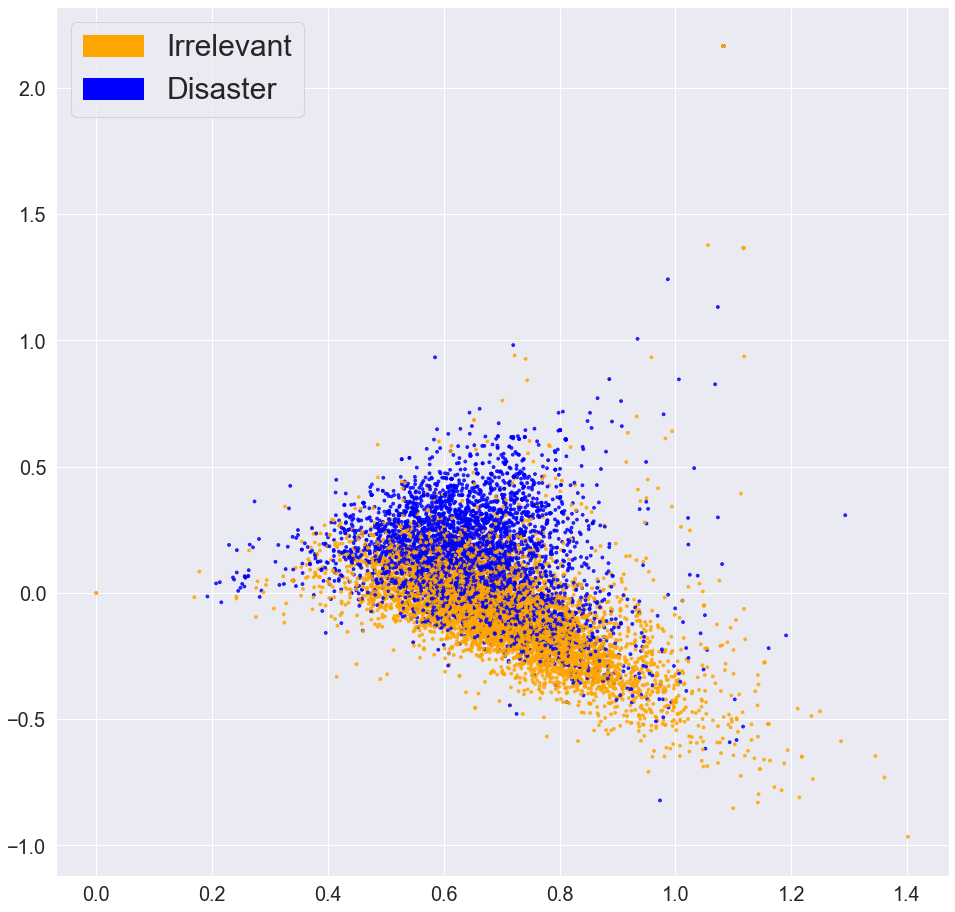

In [452]:
# plot the LSA reduced embeddings in 2 dimensions to see their separation
fig = plt.figure(figsize=(16, 16))          
plot_LSA(embeddings, list_labels)
plt.show()

**Much better separation than TF-IDF bag of words. It is much more likely this time that we will improve our model's performance.**

In [455]:
# define model again for reproducilibity and sanity
clf_w2v = LogisticRegression(
    C=30.0, 
    class_weight='balanced', 
    solver='newton-cg', 
    random_state=69
)

# fit model on word2vec embeddings 
clf_w2v.fit(X_train_word2vec, y_train_word2vec)

# get predictions on word2vec embeddings
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [456]:
# get model performance metrics on word2vec embeddings 
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print(f'accuracy = {accuracy_word2vec:.3f}, precision = {precision_word2vec:.3f}, recall = {recall_word2vec:.3f}, f1 = {f1_word2vec:.3f}')

accuracy = 0.796, precision = 0.796, recall = 0.796, f1 = 0.796


Slightly better again, if not a somewhat negligible. Let's check the confusion matrix again.

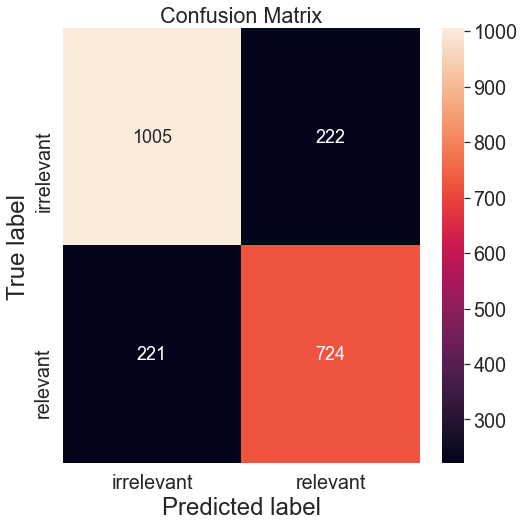

Word2Vec:
[[1005  222]
 [ 221  724]]
TF-IDF:
[[990 237]
 [231 714]]
Bag of Words:
[[997 230]
 [250 695]]


In [458]:
# plot confusion matrix on word2vec embeddings
cm_word2vec = plot_cm(y_test, y_predicted_word2vec)
print(f'Word2Vec:\n{cm_word2vec}')
print(f'TF-IDF:\n{cm_tfidf}')
print(f'Bag of Words:\n{cm_bagofwords}')

**Considerably fewer false positives and false negatives. A large improvement over TF-IDF bag of words. In addition, the model should now be much more interpretable and make more sense with its predictions.**

### Intepretability with LIME
Because we use a 300-dimensional vector for each word, it is not as simple to visualize the most important words. 

**Now, we'll have to use a black-box explainer algorithm such as LIME, introduced in [Ribeiro et al 2016, "Why Should I Trust You?": Explaining the Predictions of Any Classifier](https://arxiv.org/abs/1602.04938).** LIME analyzes the prediction on a particular example and learns an interpretable model local to that prediction - performing this operation many times, we can get a general idea of our model's decision-making process.

In [470]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

# create fresh 80/20 train/test split for use with LIME
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=69)
# word2vec pretrained model with 300-dim vector embeddings for all words in its 3-million long vocabulary
vector_store = word2vec

# make a pipeline to make predictions on word2vec embeddings of tweets 
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

In [471]:
# function applying LimeTextExplainer on a single tweet 
def explain_one_instance(instance, class_names):
    # instantiate LIME explainer 
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

# function to visualize LimeTextExplainer's output on a single tweet; wraps explain_one_instance
def visualize_one_exp(features, labels, index, class_names = ["irrelevant","relevant"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print(f'Index: {index}')
    print(f'True class: {class_names[labels[index]]}')
    exp.show_in_notebook(text=True)

In [469]:
# interpret and visualize model's prediction on one tweet
visualize_one_exp(X_test_data, y_test_data, 6)

Index: 6
True class: irrelevant


Looks like a good classification of an irrlevant tweet on a particularly difficult example. The model appears to be ignoring completely unimportant words and using some particularly unassuming words such as "career" and "compete" in predicting a tweet to be irrelevant. One might have expected the words "annihilated" and "florida" together to be classified as relevant, so word2vec is clearly a strong player for NLP embeddings. 

In [466]:
# interpret and visualize model's prediction on one tweet
visualize_one_exp(X_test_data, y_test_data, 2)

Index: 2
True class: relevant


Excellent - the model ignores unimportant words and focuses on words that indeed might refer to or predict a possible disaster.

**We can use LIME on a blackbox model to extract coefficients of words, even though the model is not trained on the actual words.** We'll have to transform word2vec embeddings back to their source words after the model is fit. 

In [472]:
import random
from collections import defaultdict

random.seed(69)

# function to get coefficients of words from model trained on word2vec embeddings
def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    # get random tweet from test set 
    sample_sentences = random.sample(test_set, sample_size)
    # instantiate LIME explainer 
    explainer = LimeTextExplainer()
    
    # dictionary to store tweets as either relevant or irrelevant   
    labels_to_sentences = defaultdict(list)
    # dictionary to store words and their weights, which contribute to a relevant or irrelevant classificaiton
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        # get predictions on random tweet embedded as word2vec 
        probabilities = word2vec_pipeline([sentence])
        # get top class prediction of tweet
        curr_label = probabilities[0].argmax()
        # append the tweet to a dictionary storing it in one of two classes
        labels_to_sentences[curr_label].append(sentence)
        # use LIME explainer to extract words contributing to the tweet's classification
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        # process contributing words to the tweet's classificaiton
        for word,contributing_weight in listed_explanation:
            # store contributing words with their weights in dictionary 
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys(), dtype='object')
        
        # average each contributing word's weight across all tweets in which it appears 
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        
        # sort by most negative word weights (coefficients) contributing to an irrelevant classificaiton
        detractors = average_contributions[curr_label].sort_values()
        
        # sort by most positive word weights contributing to a relevant classification
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        
        # dict storing contributing words to each class
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
        
    return sorted_contributions

label_to_text = {
    0: 'Irrelevant',
    1: 'Relevant',
}

# get sorted contributions of all words from 100 tweets from the test dataset
sorted_contributions = get_statistical_explanation(X_test_data, sample_size=100, word2vec_pipeline, label_to_text)

SyntaxError: positional argument follows keyword argument (<ipython-input-472-5d343337cbdd>, line 70)

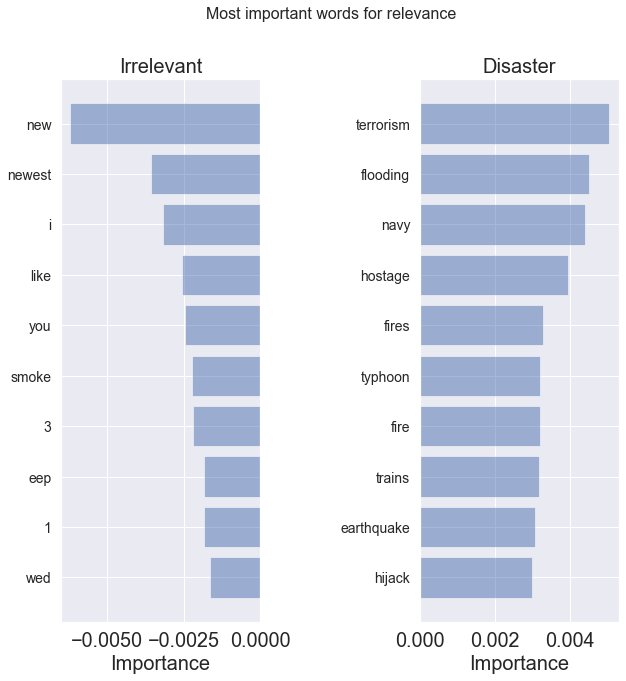

In [473]:
# Visualize the sorted contributions from all words
# First index is the class (Disaster)
# Second index is 0 for detractors, 1 for supporters
# Third is how many words we sample
top_words = sorted_contributions['Relevant']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['Relevant']['supporters'][:10].tolist()
bottom_words = sorted_contributions['Relevant']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['Relevant']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

As expected, the logistic regression model is now classifying words in a highly understandable way thanks to our efforts to imrpove the tweet embeddings. **The model no longer picks up on completely irrelevant words in classifying disaster-relevant tweets. While Word2Vec has only slightly improved the model's performance metrics, it has greatly improved the model's interpretaibility and ability to classify based on words which are truly relevant in their semantic similarity to disasters.**

# Using CNNs for Text Classification
We have built a simple model on a cleaned-up dataset, understood its predictions and mistakes, and have greatly improved our model's performance in terms of intrepretability by improving our text feature engineeiring using Word2Vec.

However, the structure of each tweet is not used as a feature, since we have averaged the Word2Vec embeddings of all words in a tweet to represent it. We are throwing away the rich syntactic data included in our tweets. **To use the structure of text data as a feature, we would usually use LSTM-RNNs or Transformers, capable of creating embeddings representing temporal structure within data. We can also use a much simpler CNN for the task.**

One such method for using CNNs on top of Word2Vec embedded text data is presented by [Kim, 2014, Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1408.5882). I'm going to loosely follow that network architecture to build a simple CNN. 

<img src="img/kim_CNN.GIF">

<sub><center> CNN architecture built on top of Word2Vec as presented in Kim, 2014: https://arxiv.org/abs/1408.5882 </center></sub>

## Preprocessing: Padding and One-Hot Encoding
**We'll have to process our dataset a little differently for this task.** I'll use Keras' tokenizer to create sequences of tokens (words) for each tweet so that we can use word2vec to create an embedding of each word, and I'll use keras' sequence tokwenizer to create word sequences which will actually represent each tweet as a sequence of word2vec embeddings. I also pad the sequences to match the longest sentence (tweet) in the dataset so that the entire dataset can be processed by the same CNN architecture. 

Finally, we have to one-hot encode the integer class labels to create a binary classification matrix. That is, each tweet in the dataset will have two columns, "is_relevant" and "is_irrelevant" instead of a single "class_label" column. 

In [478]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.utils import to_categorical

# constants for the dataset 
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = max(sentence_lengths)
VOCAB_SIZE = len(VOCAB)
VALIDATION_SPLIT=.2

# process dataset into words to create word2vec embeddings
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(clean_tweets["text"].tolist())
word_index = tokenizer.word_index

# process dataset into word sequences to represent tweets 
sequences = tokenizer.texts_to_sequences(clean_tweets["text"].tolist())

# pad word sequences to match length of longest tweet (sentence)
cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
# one-hot encode the class labels 
labels = to_categorical(np.asarray(clean_tweets["class_label"]))

# create word2vec embeddings for each word in the tokenized words 
word2vec_embeddings = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word, index in word_index.items():
    # give words a random 300-dimensional embedding if not in the 3-million long vocabulary of word2vec (unlikely)
    word2vec_embeddings[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)

print(f'Found {len(word_index)} unique words.')
print(f'Word2Vec embedded tweets: {embedding_weights.shape}')

Found 19083 unique words.
Word2Vec embedded tweets: (19082, 300)


# 1D Word2Vec CNN 
Now that the data is in a form readily acceptable by a 1D CNN, we build the model similar to Kim, 2014, with a few modifications such as a final convolutional and global maxpool as the final layer. 

In [484]:
from keras.layers import Dense, Input, Flatten, Dropout, Concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model

# define 1D CNN similar to Kim, 2014 https://arxiv.org/abs/1408.5882
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    #### 1st Conv1D layer ###
    conv1D_1 = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pooled_conv1 = MaxPooling1D(pool_size=3)(conv1D_1)

    #### 2nd Conv1D layer ###
    copv1D_2 = Conv1D(filters=128, kernel_size=4, activation='relu')(embedded_sequences)
    pooled_conv2 = MaxPooling1D(pool_size=3)(copv1D_2)

    #### 3rd Conv1D layer ###
    conv1D_3 = Conv1D(filters=128, kernel_size=5, activation='relu')(embedded_sequences)
    pooled_conv3 = MaxPooling1D(pool_size=3)(conv1D_3)

    conv_net = [pooled_conv1, pooled_conv2, pooled_conv3]

    concat = Concatenate(axis=1)(conv_net)

    # global maxpool layers are commonly helpful as final CNN layer for NLP; not used in Kim 2014 CNN model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(concat)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
        
    # flatten output of the conv layers 
    x = Flatten()(x)
    
    # pass output of conv layers through dense feedforward network 
    x = Dense(128, activation='relu')(x)
    
    # optional dropout on final output
    #x = Dropout(0.5)(x)
    
    # get sigmoid activaiton on model's output for prediction
    # can use softmax if we had more class labels such as "possible disaster"
    predictions = Dense(labels_index, activation='sigmoid')(x)
    
    # using adam as optimizer and 
    model = Model(sequence_input, predictions)
    # using standard binary cross entropy; we would use categorical crossentropy if we had more class labels
    model.compile(loss='BinaryCrossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

Now we can test our model. We split the data into 80/10/10 train/validation/test and we're good to go.

In [489]:
# use sklearn's train_test_split to split into 80/10/10 train/validation/test
# first split into 80/20 train/test+val
X_train, X_testval, y_train, y_testval = train_test_split(cnn_data, labels, test_size=0.2, random_state=69)
# then split the 20% test+val 50/50 so we end up with 80/10/10 split
X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size=0.5, random_state=69)

# check split data shape
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}, X_val: {X_val.shape}, y_val: {y_val.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}\n')

# instantiate 1D CNN model
model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, embedding_weights.shape[0], EMBEDDING_DIM, 
                len(list(clean_tweets["class_label"].unique())), extra_conv=False)

# Fit model on training data, track progress on validation data
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=128)

X_train: (8688, 34), y_train: (8688, 2), X_val: (1086, 34), y_val: (1086, 2), X_test: (1086, 34), y_test: (1086, 2)

Epoch 1/30
68/68 [==============================] - 2s 29ms/step - loss: 0.6005 - acc: 0.6817 - val_loss: 0.5012 - val_acc: 0.7652
Epoch 2/30
68/68 [==============================] - 2s 28ms/step - loss: 0.4906 - acc: 0.7758 - val_loss: 0.4731 - val_acc: 0.7753
Epoch 3/30
68/68 [==============================] - 2s 28ms/step - loss: 0.4543 - acc: 0.7912 - val_loss: 0.4611 - val_acc: 0.7827
Epoch 4/30
68/68 [==============================] - 2s 30ms/step - loss: 0.4218 - acc: 0.8141 - val_loss: 0.4682 - val_acc: 0.7928
Epoch 5/30
68/68 [==============================] - 2s 31ms/step - loss: 0.3873 - acc: 0.8276 - val_loss: 0.4673 - val_acc: 0.7901
Epoch 6/30
68/68 [==============================] - 2s 33ms/step - loss: 0.3551 - acc: 0.8508 - val_loss: 0.4672 - val_acc: 0.7928
Epoch 7/30
68/68 [==============================] - 2s 33ms/step - loss: 0.3271 - acc: 0.8606 - v

Now we can test our model against the test data. **Note that we track the performance of our model on validation data to tune its hyperparameters; we never check its performance against test data until we have completely optimized and are satisifed with our finalized model.**

In [490]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print(f"test loss: {results[0]:.3f} test acc: {results[1]*100:.3f}%")

Evaluate on test data
9/9 [==============================] - 0s 9ms/step - loss: 0.8099 - acc: 0.7956
test loss: 0.810 test acc: 79.558%


Not bad - a similar result to the Logistic Regression model applied on Word2Vec embeddings. 

**This result certainly speaks more to the value of a properly tuned and interpretable simple model as opposed to more complicated models, which do not always improve performance. We could likely improve the performance significantly using the contemporary Transformer architecture, although the complexity of the Transformer is beyond the difficulty of classification for this dataset - I think we would be better off inspecting and cleaning our dataset, and testing other simple models such as the Random Forest classifier.**

# Take-Away

The point of this notebook is to serve as an intro to NLP to get direction for where and how to proceed in improving performance of text clustering and classification algorithms, whether that entails further dataset processing - a commonly productive endeavour - or in employing a more complicated model. 

The steps I've taken here are 
 1. Clean up the dataset 
 2. Use a simple, interpretable model to benchmark performance
 3. Interpret and understand the model's predictions and especially, mistakes
 4. Clean up the dataset further if any issues have arisen
 5. Improve feature engineering on the dataset 
 6. Improve model, whether tuning or building complexity
 
 And we've seen that a more complicated model is not necessarily the better model, as in the example 1D CNN on top of Word2Vec I built above.
 
**Thanks for checking out this notebook. If you have any questions or corrections, feel free to drop me a line at ilzenkov@gmail.com.**